In [6]:

%matplotlib qt
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from pipeline import Pipeline
from mne_bids import BIDSPath

In [7]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

### Loading data

In [11]:

pipeline = Pipeline(bids_path)
pipeline.load_data()
raw = pipeline.raw

INFO:root:Loading Data


In [12]:
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 460)]
_ = plt.plot(times, data.T)
_ = plt.title('Sample channels')

### Information

In [13]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}....'.format(', '.join(ch_names[:5])))
# Give the sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('%s channels x %s samples' % (len(raw), len(raw.times)))
print(ch_names)

the (cropped) sample data object has 393216 time samples and 33 channels.
The last time sample is at 383.9990234375 seconds.
The first few channel names are FP1, F3, F7, FC3, C3....
sample rate: 1024.0 Hz
393216 channels x 393216 samples
['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'HEOG_left', 'HEOG_right', 'VEOG_lower']


### Since, P300 lets see Pz channel 

In [14]:
eeg_channel_indices = mne.pick_channels(raw.ch_names, ['Pz'])

start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sfreq).astype(int)

eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data)

import seaborn as sns
plt.plot(times, eeg_data.T)
# plt.plot(eeg_data[1], eeg_data[0].T)

[[0.03274586 0.03273805 0.03273127 ... 0.03288805 0.03289895 0.03289895]]


### Display Montage settings

In [15]:
import seaborn as sns
# sns.lineplot(data=eeg_data, x=0, y=1)
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')

print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(ten_twenty_montage, match_case=False)
print(ten_twenty_montage)

fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw.plot_sensors(ch_type='eeg', axes=ax2d)
raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)


BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'artinis-brite23.elc', 'artinis-octamon.elc', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']
<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


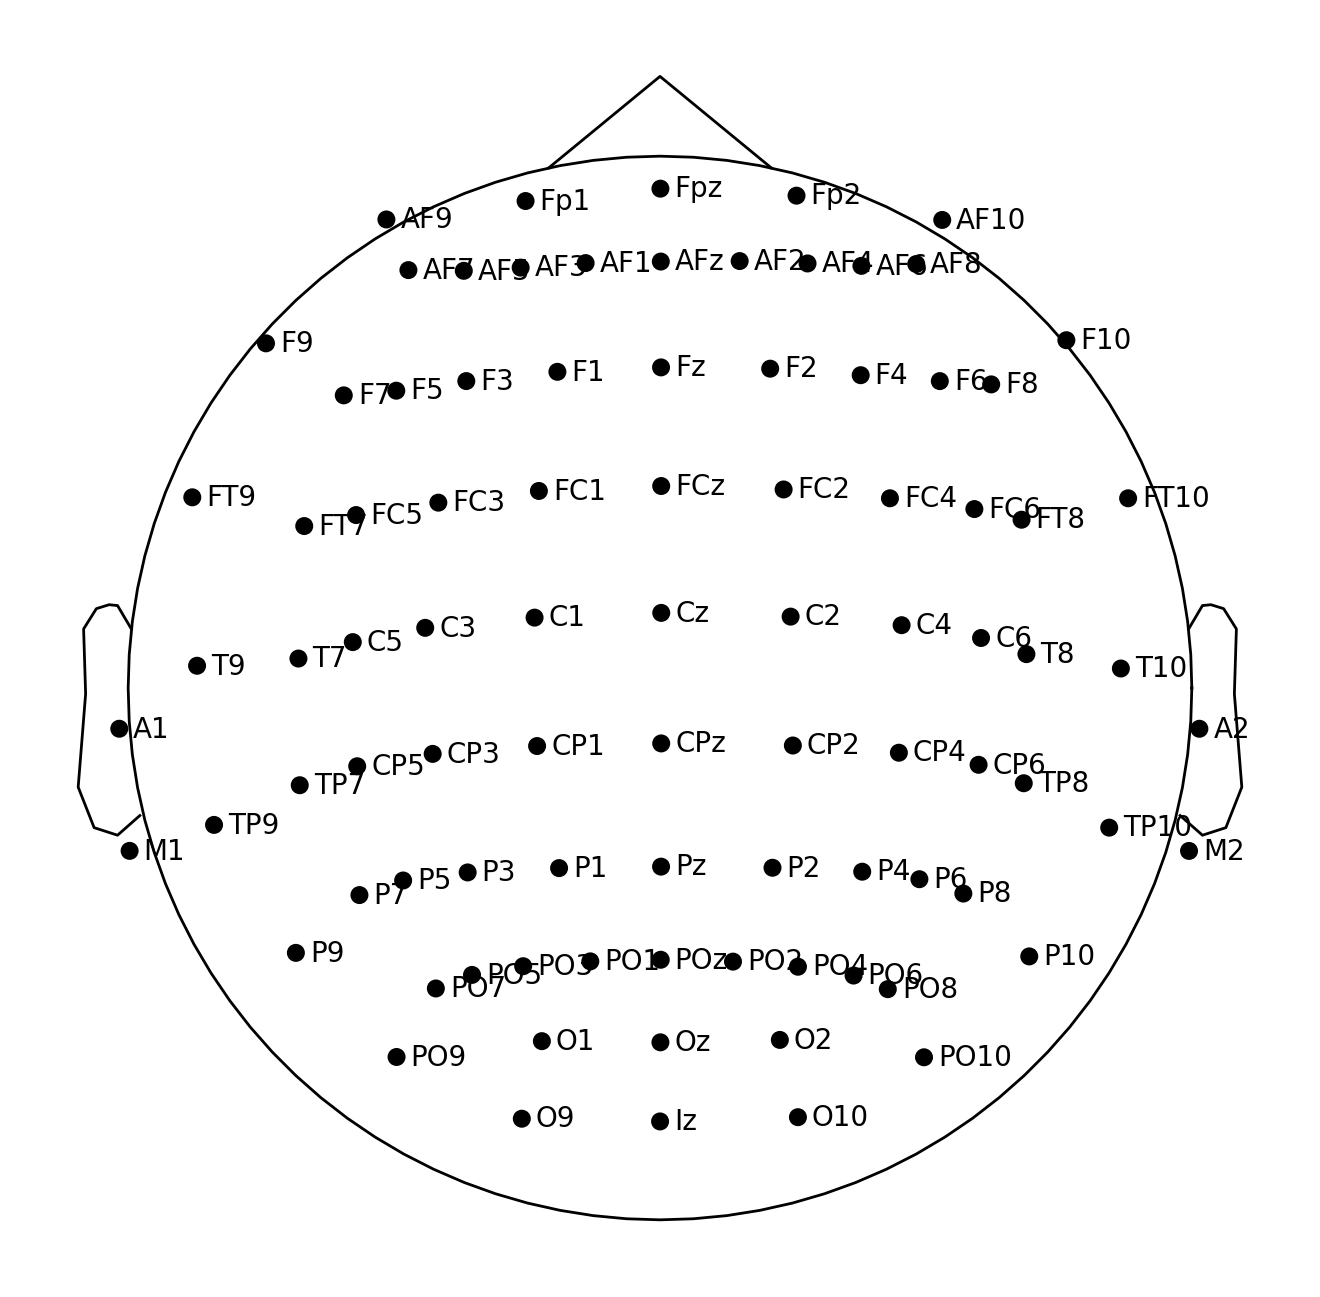

In [16]:
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=True)

### Filtering

In [17]:
raw.resample(300, npad="auto")
raw.filter(0.5, 50, fir_design='firwin')

<RawEEGLAB | sub-030_ses-P3_task-P3_eeg.fdt, 33 x 115200 (384.0 s), ~29.1 MB, data loaded>

## Removing muscle artifact

In [18]:
# The threshold is data dependent, check the optimal threshold by plotting
# ``scores_muscle``.
threshold_muscle = 25  # z-score
# Choose one channel type, if there are axial gradiometers and magnetometers,
# select magnetometers as they are more sensitive to muscle activity.
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

In [19]:
fig, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity')]

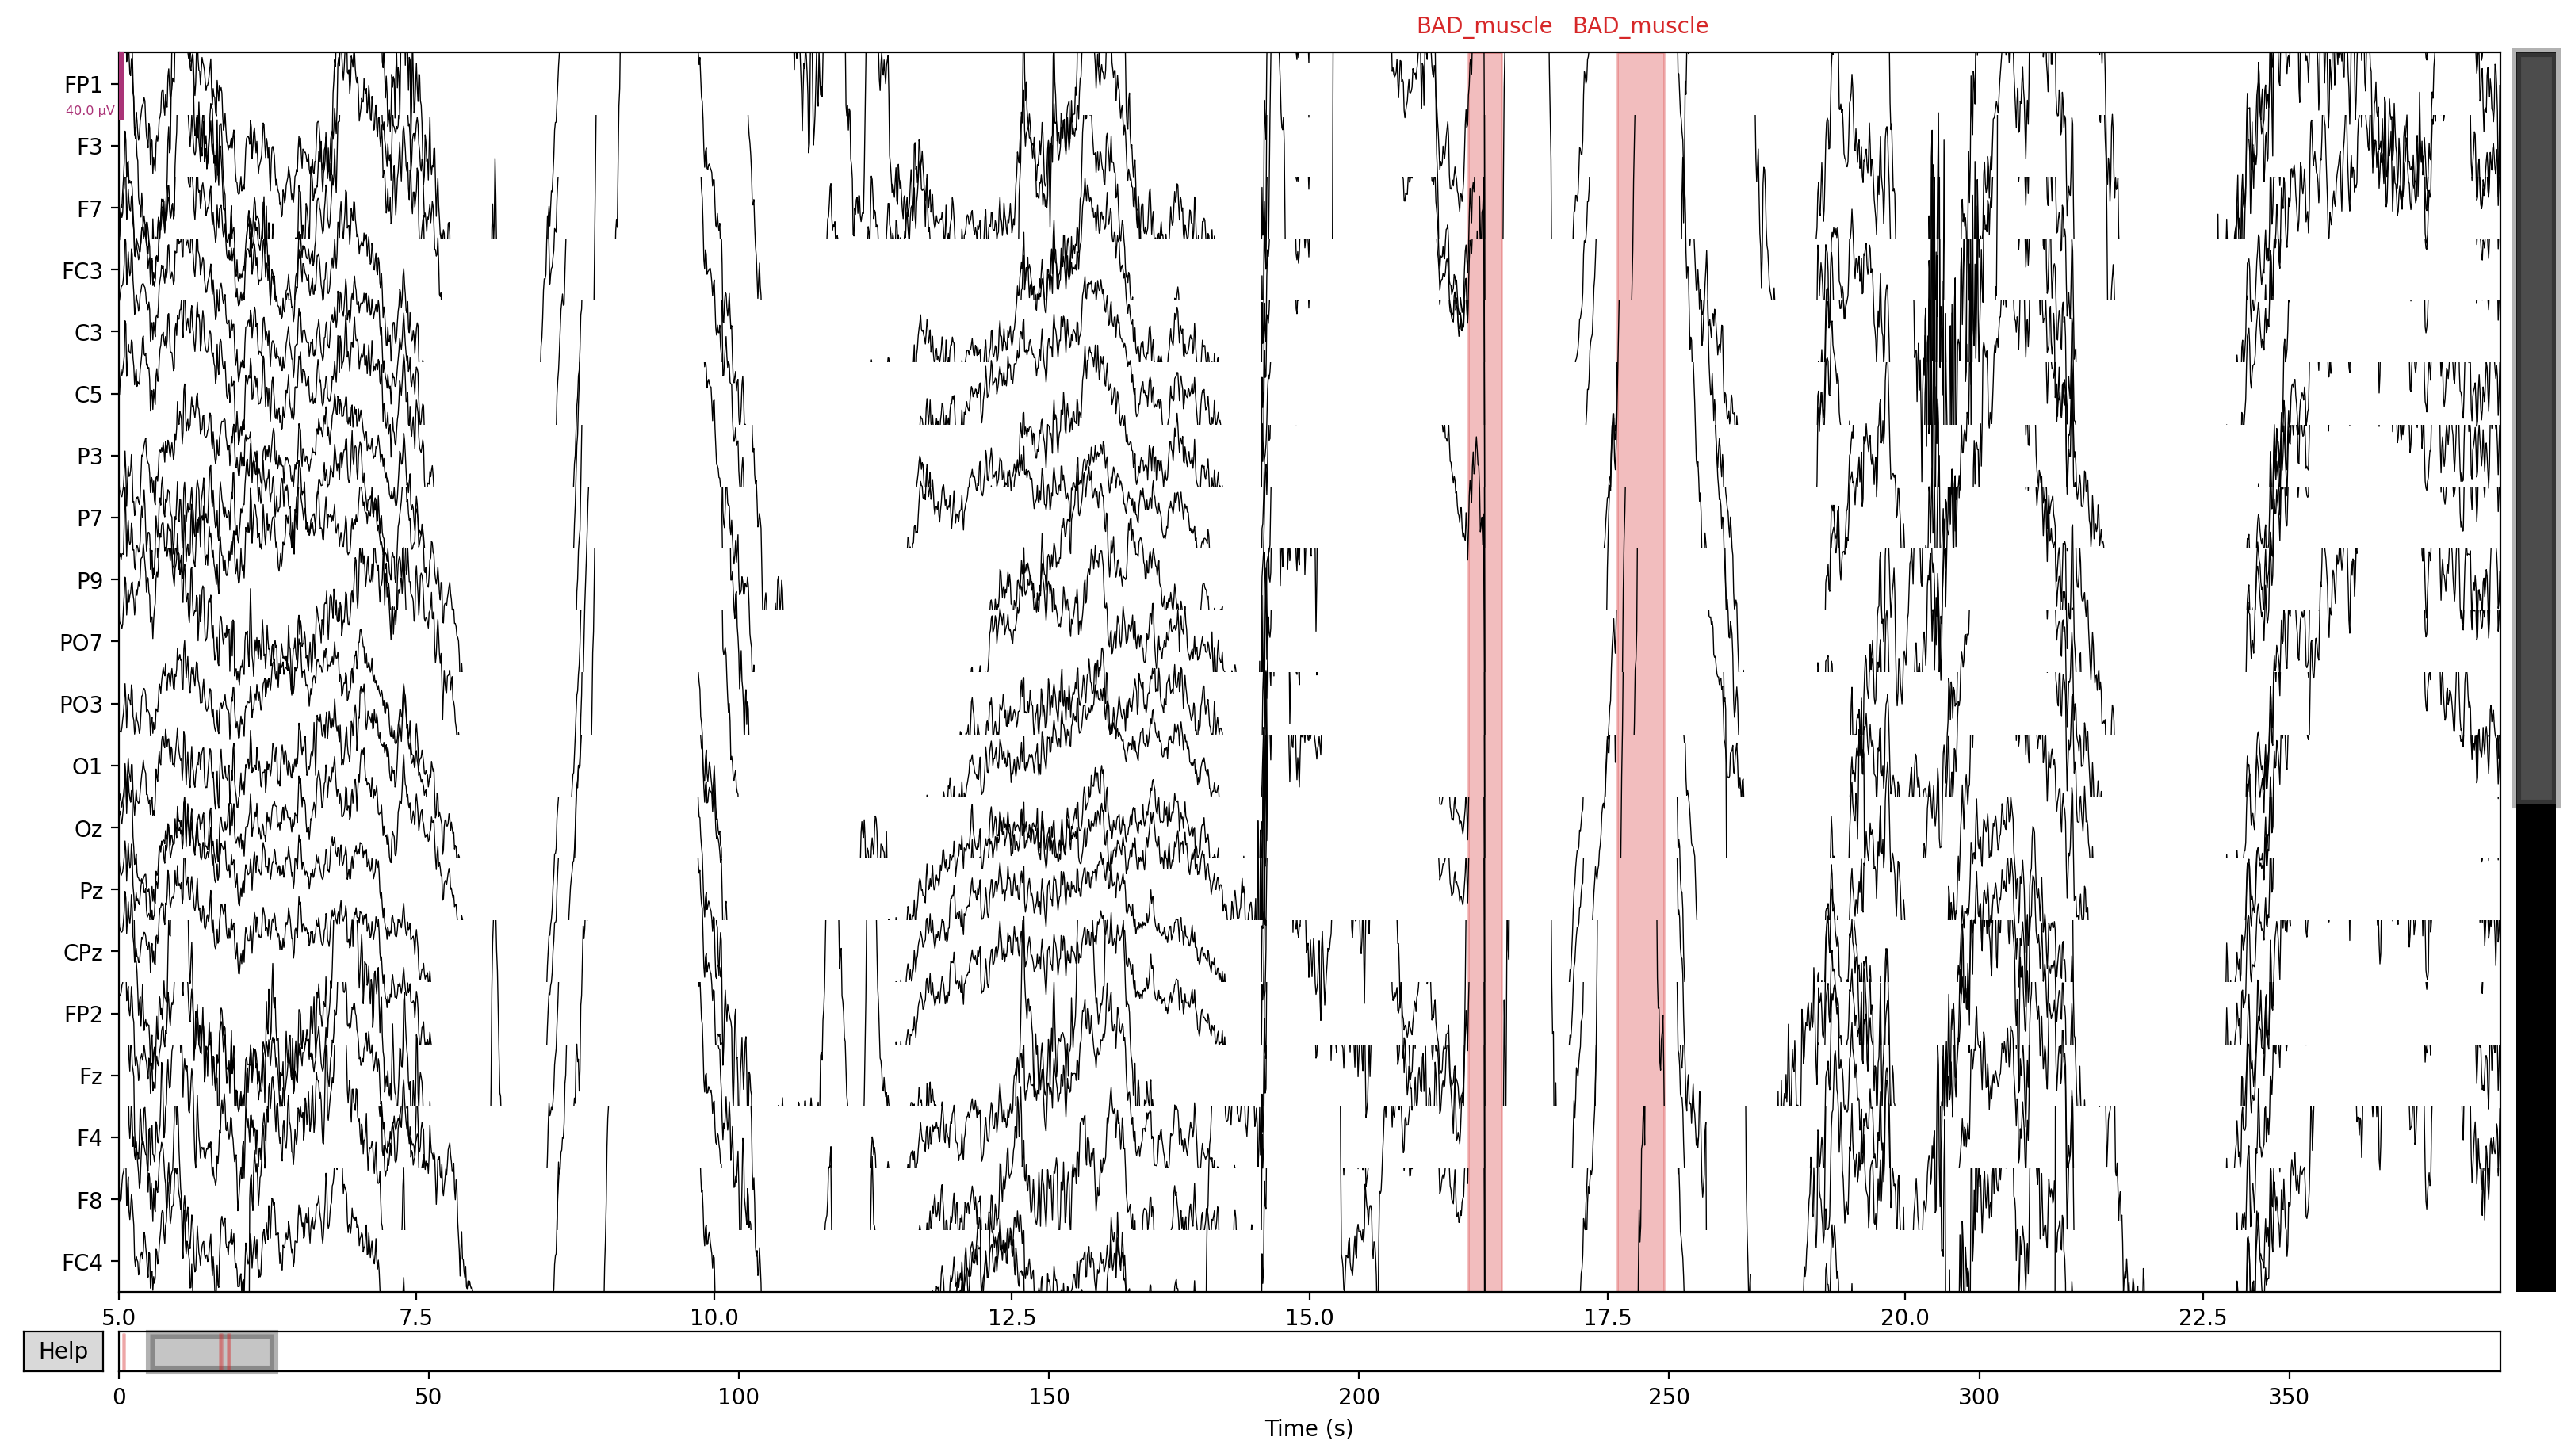

In [20]:
order = np.arange(144, 164)
nraw = raw.copy()
nraw.set_annotations(annot_muscle)
nraw.plot(start=5, duration=20)

In [21]:
eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['bad blink'] * len(eog_events)
blink_annot = mne.Annotations(onsets, durations, descriptions,
                              orig_time=raw.info['meas_date'])
raw.set_annotations(blink_annot)

<RawEEGLAB | sub-030_ses-P3_task-P3_eeg.fdt, 33 x 115200 (384.0 s), ~29.1 MB, data loaded>

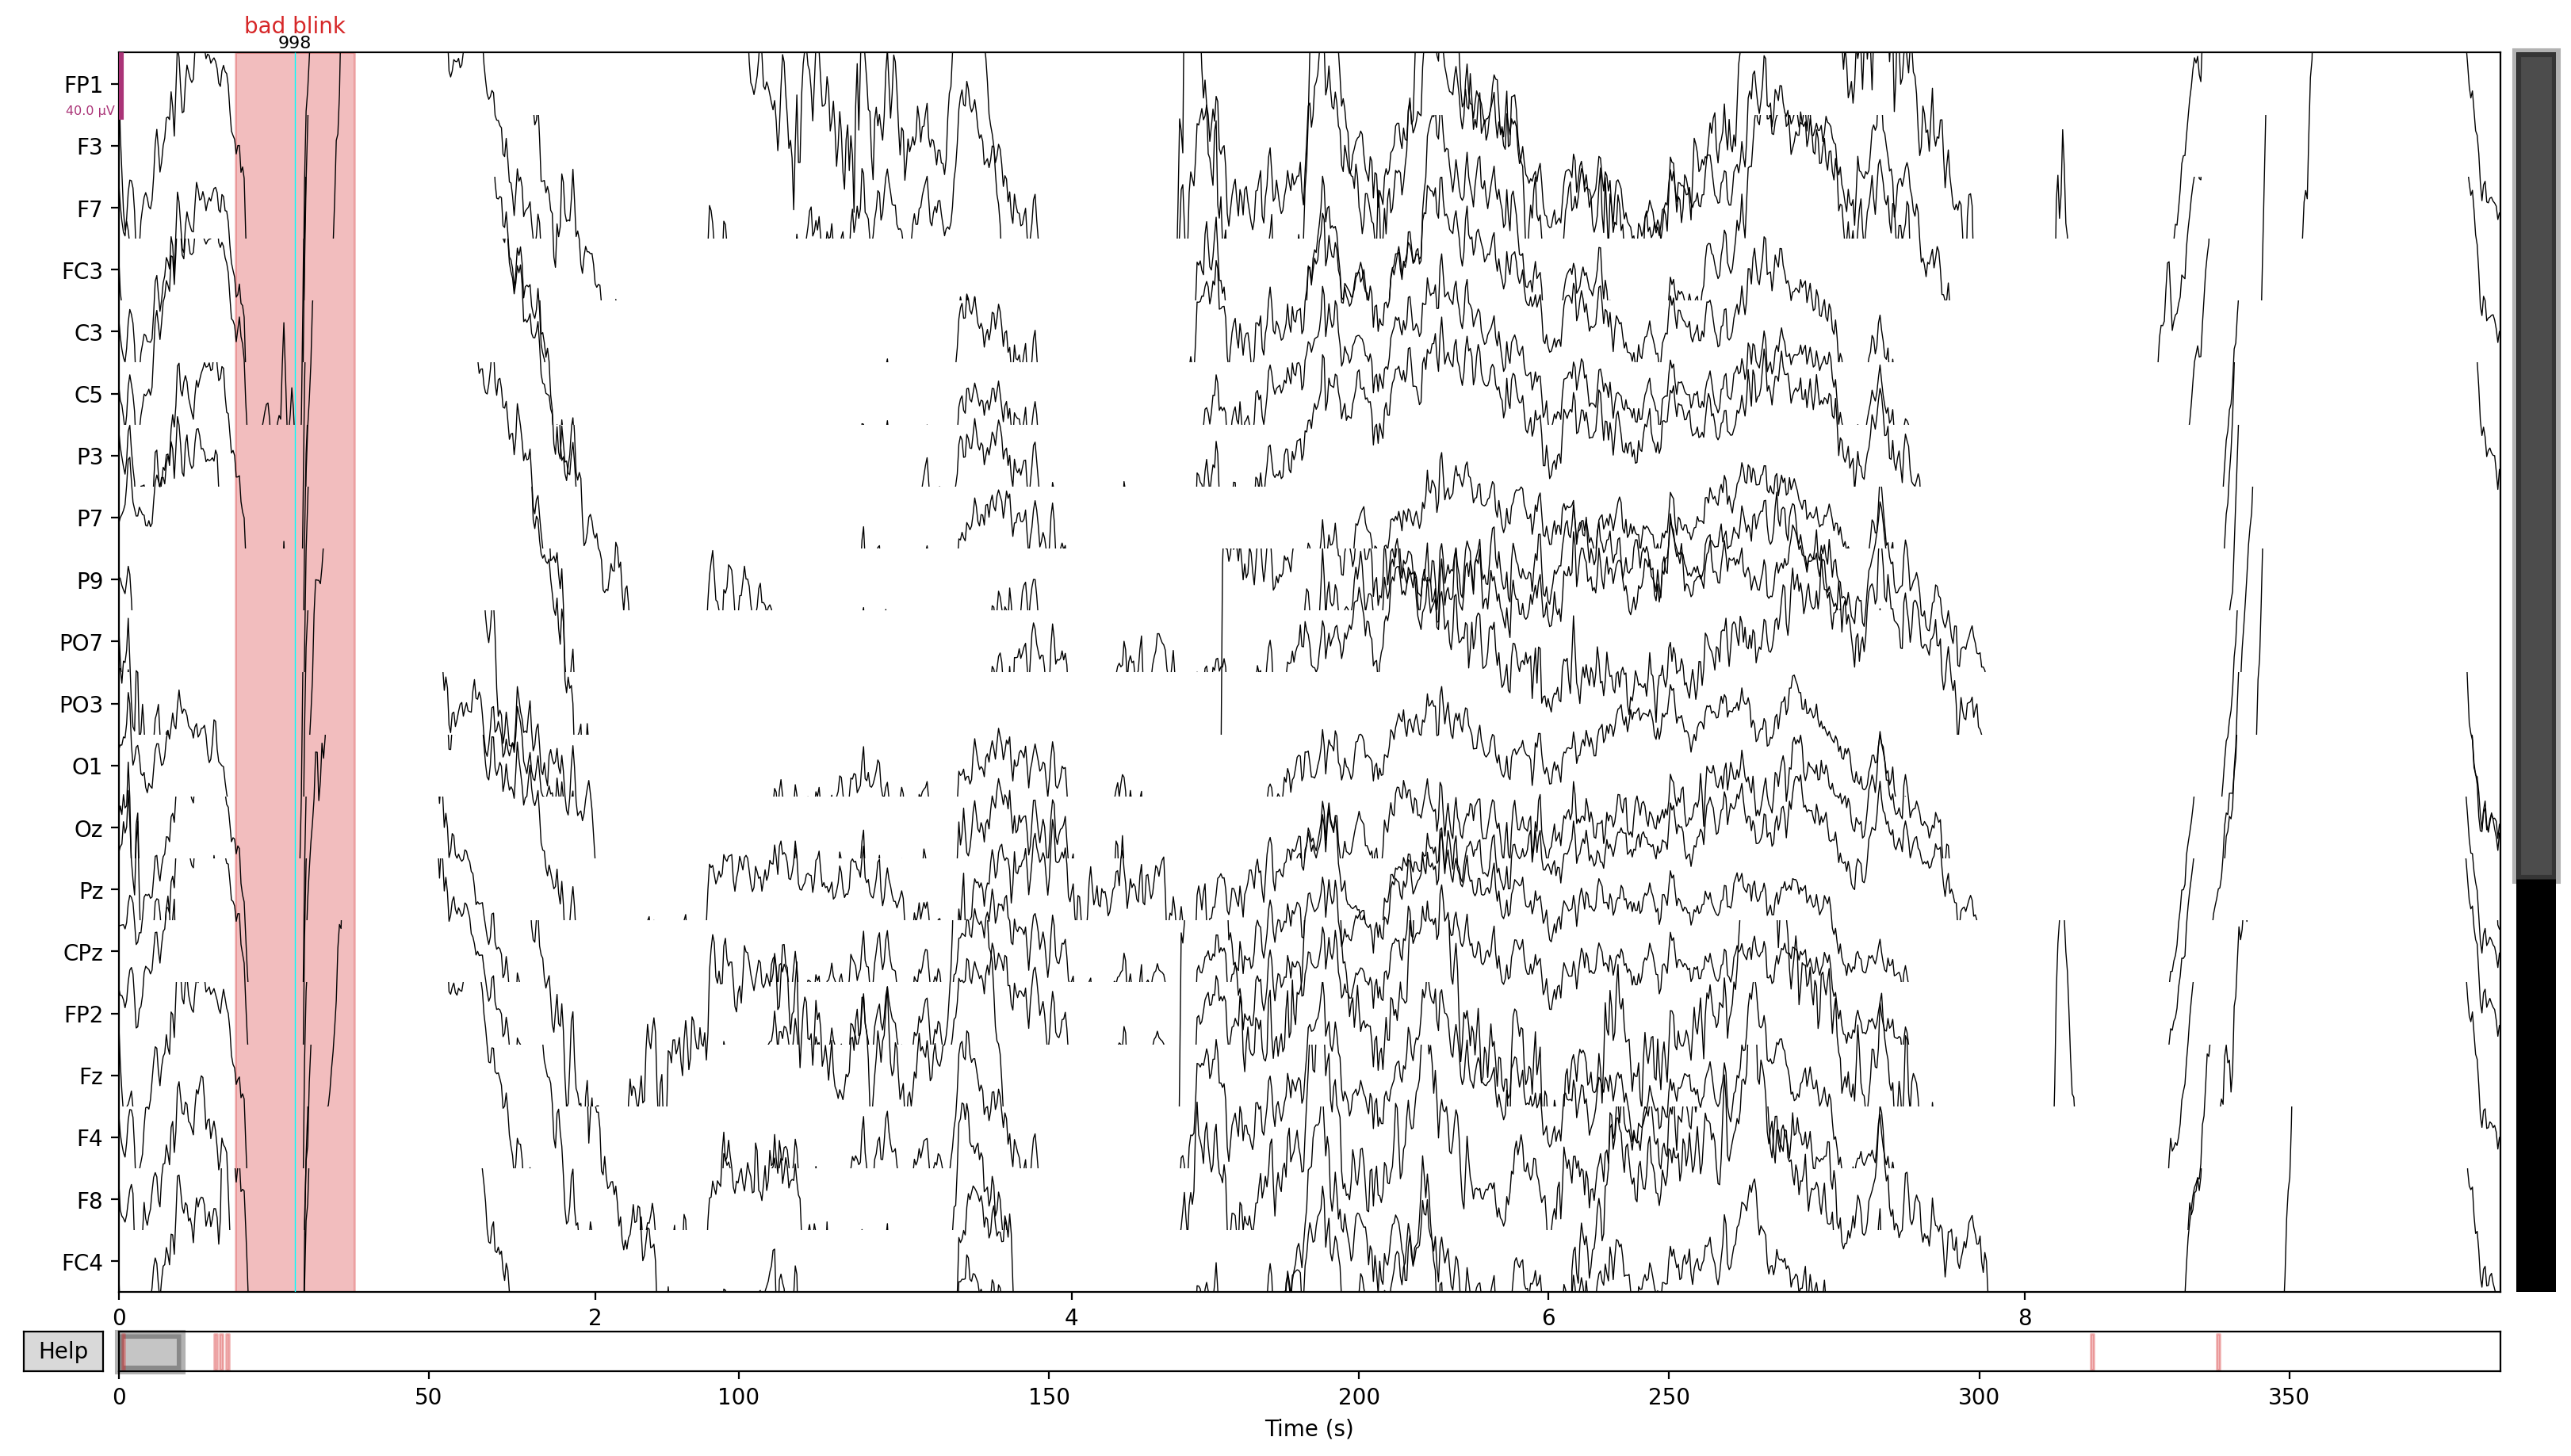

In [22]:
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)
raw.plot(events=eog_events, order=eeg_picks)

In [23]:
reject_criteria = dict(eeg=100e-6,       # 100 µV
                       eog=200e-6)       # 200 µV

flat_criteria = dict(eeg=1e-6)           # 1 µV
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, reject_tmax=0,
                    reject=reject_criteria, flat=flat_criteria, preload=True)
epochs.plot_drop_log()

NameError: name 'events' is not defined

### ICA

In [ ]:
ica = mne.preprocessing.ICA(method="fastica")
ica.fit(raw,decim=3, verbose=True)
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores, exclude=eog_indices)

In [ ]:
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq']);

In [ ]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
# ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=True)


# ica.plot_overlay(raw, exclude=eog_indices, picks='eeg')

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

In [ ]:
from time import time
def run_ica(method, fit_params=None):
    ica = mne.preprocessing.ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=35)
    t0 = time()
    ica.fit(nraw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

In [ ]:
run_ica('fastica')

In [ ]:
run_ica('picard')

In [ ]:
run_ica('infomax')

In [ ]:
raw.plot_psd(average=True)

### EPOCHING

In [ ]:
epochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)
print(epochs)

In [ ]:
print(epochs.events[:3])
print(epochs.event_id)

In [ ]:
print(epochs[1:5])
print(epochs['stimulus/11'])
print(epochs['stimulus/21'])
print(epochs['stimulus/31'])
print(epochs['response'])

In [ ]:
epochs.plot_drop_log();

In [ ]:
# epochs.plot(block=True, events=events);

In [ ]:
epochs.plot_image(12, cmap='interactive', sigma=1., vmin=-400, vmax=400);

In [ ]:
stim_events = dict((k, event_id[k]) for k in event_id.keys() if "stimulus" in k)
epochs = mne.Epochs(raw, events, stim_events, tmin=-0.2, tmax=0.8, picks=['Pz'])


# Average epochs for faces and car
rare_stim = set(range(11, 55+1, 11))
freq_stim = set(range(11, 55+1)) - set(range(11, 55+1, 11))

evoked_a = epochs[["stimulus/{}".format(f) for f in rare_stim]].average()
evoked_b = epochs[["stimulus/{}".format(f) for f in freq_stim]].average()

# Plot evokeds
mne.viz.plot_compare_evokeds({"Target A": evoked_a, "Target B": evoked_b}, show=False, title="ERPs before ICA", combine="mean")

In [ ]:
rare_stim